# Elo Merchant Category Recommendation
## 1. Descriptive Statistics 1.
End date: _2019. february 19._<br/>

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Contents of this notebook:
* [Train and test data](#Train-and-test-data) Data of customers' cards
    * [card_id](#card_id)
    * [first_active_month](#first_active_month)
    * feature_1,-feature_2,-feature_3
    * [target](#target)
* [Transactions](#Transactions) Card transactions for both train and test data
    * [authorized_flag](#authorized_flag)
    * [card_id](#card_id)
    * [state_id](#state_id)
    * [city_id](#city_id)
    * category_1, category_2, category_3
    * installments, purchase_amount
    * merchant_id, merchant_category_id, subsector_id
    * [month_lag](#month_lag)
    * [purchase_date](#purchase_date)
* [Merchants](#Merchants) Data of merchants
    * merchant_group_id, merchant_category_id, subsector_id, city_id, state_id
    * numerical_1, numerical_2
    * category_1, category_2, category_4
    * most_recent_sales_range, most_recent_purchases_range
    * avg_sales_lag3, avg_sales_lag6, avg_sales_lag12
    * avg_purchases_lag6, avg_purchases_lag12

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)
threshold = 0.5

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def displayDataInHTMLTable(columns, rows, df):
    html = '<table>'
    html+= '<thead><tr><th>&nbsp;</th>'
    for col_item in columns:
        html+= '<th>' + str(col_item) + '</th>'
    html+= '</tr></thead><tbody>'

    for x in range(0, len(df)):
        html+= '<tr>'
        html+= '<td><b>' + rows[x] + '</b></td>'

        for y in range(0, len(df[0])):
            html+= '<td>' + df[x][y] + '</td>'
    html+= '</tr>'

    html+= '</tbody></table>'
    display(HTML(html))

## Train and test data
The training and test data sets contain card_id's and information about the cards themselves.

In [4]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

201,917 records and 6 features in train set.
123,623 records and 5 features in test set.
Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [5]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988


In [6]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1


As you can see, the only difference between the training and test data set is the test data set does not have target features. Now let's check the variables one by one.

### card_id

In [7]:
df_train[df_train['card_id'].isin(df_test['card_id'].values)]

,first_active_month,card_id,feature_1,feature_2,feature_3,target


Double checked that the training and the test set of card_ids don't have an intersection.

In [8]:
print("Number of unique card IDs in the training set: {:,}".format(len(df_train['card_id'].unique())))
print("Number of unique card IDs in the test set: {:,}".format(len(df_test['card_id'].unique())))

Number of unique card IDs in the training set: 201,917
Number of unique card IDs in the test set: 123,623


As you can see the number of unique records are exactly the same as the number of total records in both sets.

### first_active_month
Let's check the range of the `first_active_month`, but first let's count the missing values in both the train and the test sets.

In [9]:
print('In the training set there are {} missing values.'.format(df_train['first_active_month'].isna().sum()))
print('In the test set there are {} missing values.'.format(df_test['first_active_month'].isna().sum()))

In the training set there are 0 missing values.
In the test set there are 1 missing values.


In [10]:
df_test[df_test['first_active_month'].isna()]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaN,C_ID_c27b4f80f7,5,2,1


In the test set, there is one NaN value for **C_ID_c27b4f80f7** `card_id`, that we need to filter out, before searching for the minimum and maximum.

In [11]:
print("The first_active_month variable in the training set is ranging from {} to {}".format(df_train['first_active_month'].min(), df_train['first_active_month'].max()))
print("The first_active_month variable in the test set is ranging from {} to {}".format(df_test[df_test['card_id'] != 'C_ID_c27b4f80f7']['first_active_month'].min(), df_test[df_test['card_id'] != 'C_ID_c27b4f80f7']['first_active_month'].max()))

The first_active_month variable in the training set is ranging from 2011-11 to 2018-02
The first_active_month variable in the test set is ranging from 2011-11 to 2018-01


It is important to know that the training set is for the same duration as the test set, so we need to predict the value of the target variable for the same period for different customers with different cards.

In [12]:
print("There are {} months between the start and end date of the training set.".format(len(df_train['first_active_month'].unique())))

There are 75 months between the start and end date of the training set.


In [13]:
q1_tr = int(df_train['first_active_month'].count()/4)
q3_tr = int(3*df_train['first_active_month'].count()/4)

q1_te = int(df_test['first_active_month'].count()/4)
q3_te = int(3*df_test['first_active_month'].count()/4)

df_train.sort_values(by='first_active_month', inplace=True, na_position='last')
df_test.sort_values(by='first_active_month', inplace=True, na_position='last')

print('Interquartile range of the training set: {} - {}'.format(df_train['first_active_month'].iloc[q1_tr], df_train['first_active_month'].iloc[q3_tr]))
print('Interquartile range of the test set: {} - {}'.format(df_test['first_active_month'].iloc[q1_te], df_test['first_active_month'].iloc[q3_te]))

Interquartile range of the training set: 2016-10 - 2017-09
Interquartile range of the test set: 2016-10 - 2017-09


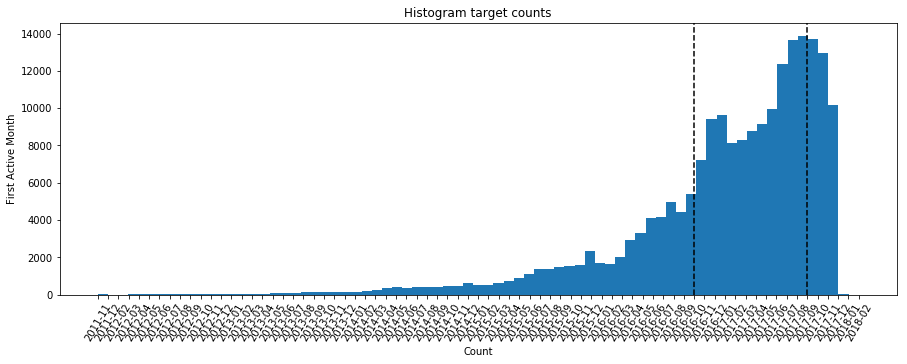

In [14]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['first_active_month'].values, bins=75)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('First Active Month')
plt.axvline('2016-10', color="k", linestyle="--")
plt.axvline('2017-09', color="k", linestyle="--")
plt.show()

The interquartile range is shown on the histogram with dashed lines.

### feature_1, feature_2, feature_3

In [15]:
displayDataInHTMLTable(
    ['Training set', 'Test set'],
    ['Feature 1', 'Feature 2', 'Feature 3'],
    [
        ['{} - {}'.format(df_train['feature_1'].min(), df_train['feature_1'].max()),
         '{} - {}'.format(df_test['feature_1'].min(), df_test['feature_1'].max())],
        ['{} - {}'.format(df_train['feature_2'].min(), df_train['feature_2'].max()),
         '{} - {}'.format(df_test['feature_2'].min(), df_test['feature_2'].max())],
        ['{} - {}'.format(df_train['feature_3'].min(), df_train['feature_3'].max()),
         '{} - {}'.format(df_test['feature_3'].min(), df_test['feature_3'].max())]
    ]
)

,Training set,Test set
Feature 1,1 - 5,1 - 5
Feature 2,1 - 3,1 - 3
Feature 3,0 - 1,0 - 1


The range of the features are the same both in training and test test.

### target

In [16]:
df_train.target.describe()

count    201917.000000
mean               NaN
std           0.000000
min         -33.218750
25%          -0.883301
50%          -0.023438
75%           0.765625
max          17.968750
Name: target, dtype: float64

The value of the target variable is ranging between -33.218751 and 17.968751. These number don't tell us much about the distribution of the variables, that's why we draw a histrogram of the values.

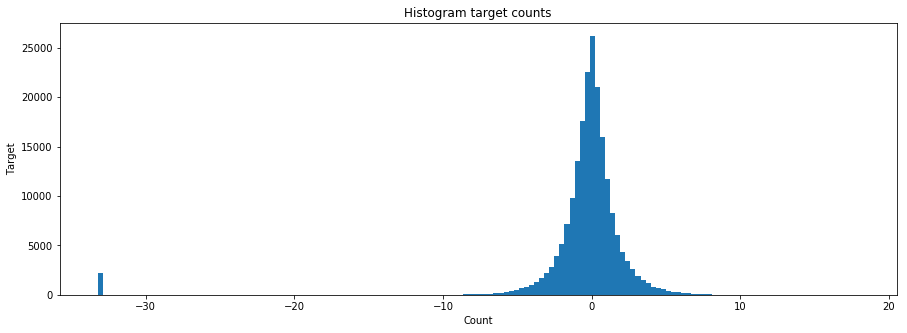

In [17]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.target.values, bins=150)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

As you can see the majority of the values are between -8 and 8, but there is a spike of outliers around -33. Previously we have found out that the mean is -0.39, and the standard deviation is 3.85.

In [18]:
train_duplicates = df_train.groupby(by='target', as_index=False).size().reset_index().rename(columns={0:'count'})
train_duplicates.sort_values(by='count', ascending=False, inplace=True)
train_duplicates[:5]

,target,count
0,-33.218750,2207
9702,0.000000,1630
16413,1.000000,145
3034,-1.000000,114
3884,-0.584961,57


In [19]:
print('There are {:,} target elements with value {:.5f}'.format(
    df_train[df_train['target'] < -30]['target'].count(),
    df_train[df_train['target'] < -30]['target'].unique()[0]
))

There are 2,207 target elements with value -33.21875


Surprisingly the spike on the left side of the histogram is 2,207 of records that have exactly the same outlier value, which seems strange. There might be something wrong with the loyalty calculator algorithm. Maybe it does not handle the outliers well? Apart from this, if we chop off the outliers, the distribution of the target values might have normal distribution. Let's check it! 

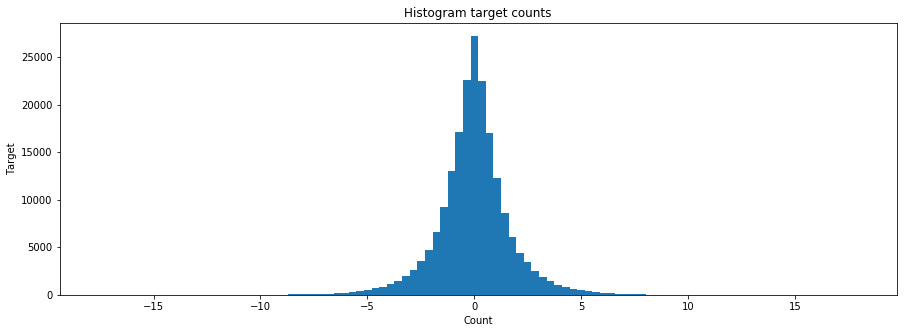

In [20]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -20].target.values, bins=100) # normal distribution
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

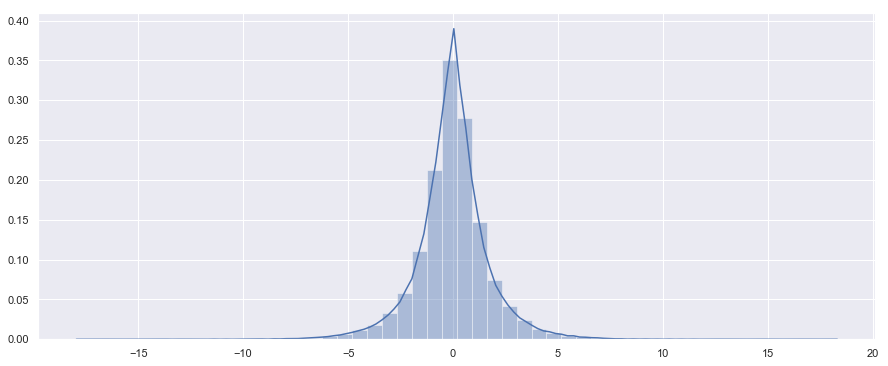

In [21]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.distplot(df_train[df_train['target'] > -20].target.values)

If we draw the line of the normal distribution to the chart, looks like it has a normal distribution, but let's go further with the checking of the statistics. The QQ plot shows the scatter plot of points in a diagonal line, closely fitting the expected diagonal pattern for a sample from a Gaussian distribution. As the plot below shows the deviations from the red line, it seems that the distribution of the target attribute is not normal.

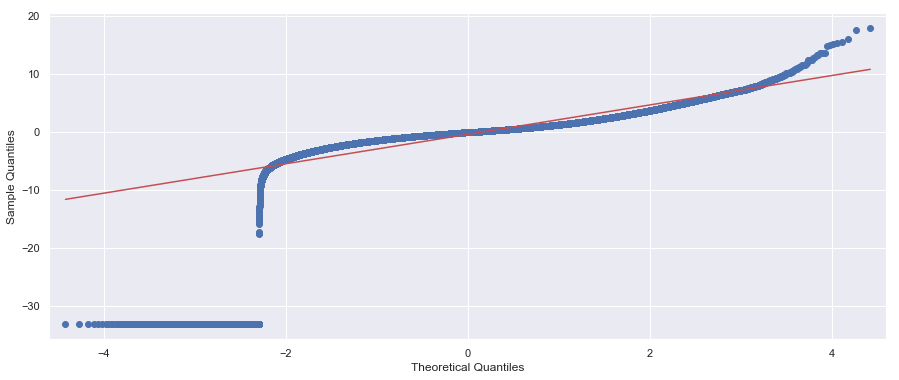

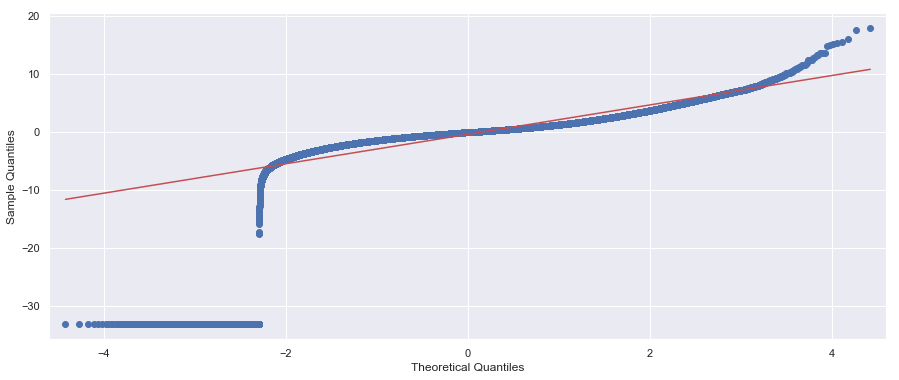

In [22]:
qqplot(df_train['target'], line='r')

In [23]:
print('Shapiro-Wilk Test normality test')
stat, p = stats.shapiro(df_train[df_train['target'] > -30].target.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.1
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test normality test
Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)


As the p value is zero, the target attribute (without the outliers) is not drawn from normal distribution at any confidence level.

## Transactions

In [5]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
print("{:,} records and {} features in historical transactions set.".format(df_hist_trans.shape[0], df_hist_trans.shape[1]))

df_hist_trans = reduce_mem_usage(df_hist_trans)

KeyboardInterrupt: 

In [5]:
df_hist_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [ ]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
print("{:,} records and {} features in new transactions set.".format(df_new_trans.shape[0], df_new_trans.shape[1]))

df_new_trans = reduce_mem_usage(df_new_trans)

In [7]:
df_new_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14


### authorized_flag

In [28]:
print('Number of unique elements of authorized_flag in the new transactions set {} {} and in the historical transactions set {} {}.'.format(
    len(df_new_trans['authorized_flag'].unique()),
    list(df_new_trans['authorized_flag'].unique()),
    len(df_hist_trans['authorized_flag'].unique()),
    list(df_hist_trans['authorized_flag'].unique())
))

Number of unique elements of authorized_flag in the new transactions set 1 ['Y'] and in the historical transactions set 2 ['Y', 'N'].


In [29]:
df_auth_new = df_new_trans.groupby("authorized_flag").size().reset_index().rename({0:'number_of_transactions'}, axis=1)
df_auth_hist = df_hist_trans.groupby("authorized_flag").size().reset_index().rename({0:'number_of_transactions'}, axis=1)

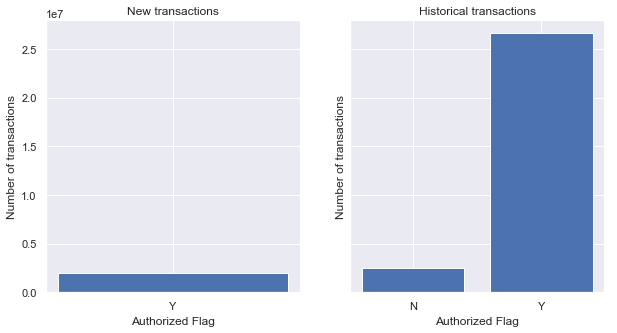

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='row')

ax[0].bar(df_auth_new['authorized_flag'], df_auth_new['number_of_transactions'], align='center')
ax[0].set_xlabel('Authorized Flag')
ax[0].set_ylabel('Number of transactions')
ax[0].set_title('New transactions')

ax[1].bar(df_auth_hist['authorized_flag'], df_auth_hist['number_of_transactions'], align='center')
ax[1].set_xlabel('Authorized Flag')
ax[1].set_ylabel('Number of transactions')
ax[1].set_title('Historical transactions')

plt.show()

Apparently there are no non-authorized transactions in the new transactions set.

### card_id

In [31]:
df_n = df_new_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)
df_h = df_hist_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)

In [32]:
displayDataInHTMLTable(
    ['Average', 'Maximum'],
    ['New transactions', 'Historical transactions'],
    [
        ['{:.4f}'.format(df_n['transactions'].mean()), '{}'.format(df_n['transactions'].max())],
        ['{:.4f}'.format(df_h['transactions'].mean()), '{}'.format(df_h['transactions'].max())]
    ]
)

,Average,Maximum
New transactions,6.7690,109
Historical transactions,89.4279,5582


### state_id

In [33]:
unique_state_ids = df_hist_trans['state_id'].unique()
unique_city_ids = df_hist_trans['city_id'].unique()

print('There are {} unique state IDs in the historical transactions set.'.format(len(unique_state_ids)))
print('There are {} unique city IDs in the historical transactions set.'.format(len(unique_city_ids)))

There are 25 unique state IDs in the historical transactions set.
There are 308 unique city IDs in the historical transactions set.


In [34]:
unique_state_ids.sort()
unique_state_ids

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

According to [Wikipedia](https://en.wikipedia.org/wiki/Brazil) there are 26 states and the Federal District in Brazil.

In [10]:
df_usn = df_new_trans.groupby("state_id").size().reset_index().rename({0:'count'}, axis=1)
df_ush = df_hist_trans.groupby("state_id").size().reset_index().rename({0:'count'}, axis=1)

In [11]:
df_ush

,state_id,count
0,-1,2652864
1,1,247753
2,2,371728
3,3,542220
4,4,840820
5,5,1655124
6,6,7233
7,7,640712
8,8,157829
9,9,10568881


In [12]:
df_usn

,state_id,count
0,-1,111745
1,1,17908
2,2,27814
3,3,38908
4,4,63532
5,5,120158
6,6,357
7,7,49342
8,8,12218
9,9,733146


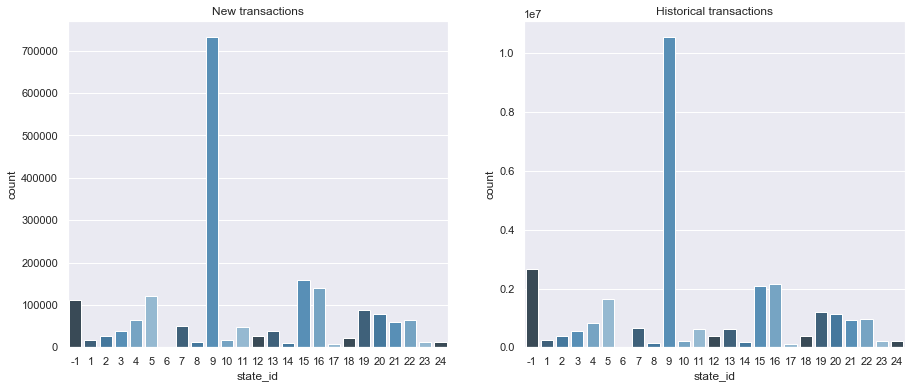

In [13]:
sns.set(rc={'figure.figsize':(15, 6)})

f, axes = plt.subplots(1, 2)

axes[0].set_title('New transactions')
axes[1].set_title('Historical transactions')
sns.barplot(x="state_id", y="count", data=df_usn, orient='v', ax=axes[0], palette=sns.color_palette("Blues_d"))
sns.barplot(x="state_id", y="count", data=df_ush, orient='v', ax=axes[1], palette=sns.color_palette("Blues_d"))

In [39]:
print('There are {:,} ({:.2f}%) values where the state_id is -1 in the historical and {:,} ({:.2f}%) in the new dataset.'.format(
    df_ush[df_ush['state_id'] == -1]['count'][0],
    df_ush[df_ush['state_id'] == -1]['count'][0]/df_hist_trans.shape[0]*100,
    df_usn[df_usn['state_id'] == -1]['count'][0],
    df_usn[df_usn['state_id'] == -1]['count'][0]/df_new_trans.shape[0]*100))

There are 2,652,864 (9.11%) values where the state_id is -1 in the historical and 111,745 (5.69%) in the new dataset.


### city_id

In [40]:
unique_city_ids.sort()
unique_city_ids

array([ -1,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,
        29,  30,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,  44,
        46,  47,  48,  49,  51,  52,  53,  54,  56,  57,  58,  60,  61,
        62,  63,  64,  65,  66,  68,  69,  70,  71,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  94,  96,  97,  98, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 131, 133, 135,
       136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194,
       195, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 20

In [41]:
df_ucn = df_new_trans.groupby("city_id").size().reset_index().rename({0:'count'}, axis=1)
df_uch = df_hist_trans.groupby("city_id").size().reset_index().rename({0:'count'}, axis=1)

In [42]:
df_ucn[:5]

,city_id,count
0,-1,99349
1,1,7415
2,2,1418
3,3,3036
4,4,16672


In [43]:
df_uch[:5]

,city_id,count
0,-1,2478624
1,1,108519
2,2,17171
3,3,42665
4,4,212403


In [44]:
print('There are {:,} ({:.2f}%) values where the city_id is -1 in the historical and {:,} ({:.2f}%) in the new dataset.'.format(
    df_uch[df_uch['city_id'] == -1]['count'][0],
    df_uch[df_uch['city_id'] == -1]['count'][0]/df_hist_trans.shape[0]*100,
    df_ucn[df_ucn['city_id'] == -1]['count'][0],
    df_ucn[df_ucn['city_id'] == -1]['count'][0]/df_new_trans.shape[0]*100
))

There are 2,478,624 (8.51%) values where the city_id is -1 in the historical and 99,349 (5.06%) in the new dataset.


### category_1, category_2, category_3

In [45]:
list(df_hist_trans['category_3'].unique())

['A', 'B', 'C', nan]

In [46]:
cat2_h = ['NaN' if math.isnan(x) else str(x) for x in list(df_hist_trans['category_2'].unique())]
cat2_n = ['NaN' if math.isnan(x) else str(x) for x in list(df_new_trans['category_2'].unique())]

cat3_h = [x if isinstance(x, str) else 'NaN' for x in list(df_hist_trans['category_3'].unique())]
cat3_n = [x if isinstance(x, str) else 'NaN' for x in list(df_new_trans['category_3'].unique())]

displayDataInHTMLTable(
    ['Historical', 'New'],
    ['category_1', 'category_2', 'category_3'],
    [
        [', '.join(list(df_hist_trans['category_1'].unique())), ', '.join(list(df_new_trans['category_1'].unique()))],
        [', '.join(cat2_h), ', '.join(cat2_n)],
        [', '.join(cat3_h), ', '.join(cat3_n)]
    ]
)

,Historical,New
category_1,"N, Y","N, Y"
category_2,"1.0, NaN, 3.0, 5.0, 2.0, 4.0","1.0, NaN, 3.0, 2.0, 4.0, 5.0"
category_3,"A, B, C, NaN","B, NaN, C, A"


Category variables need to be converted to integers or dummy variables.

### installments, purchase_amount

In [47]:
print('New installments range: {} - {}'.format(df_new_trans['installments'].min(), df_new_trans['installments'].max()))
print('Historical installments range: {} - {}'.format(df_hist_trans['installments'].min(), df_hist_trans['installments'].max()))

New installments range: -1 - 999
Historical installments range: -1 - 999


According to [Elo](https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/72993), both -1 and 999 indicates missing values.

In [48]:
df_uin = df_new_trans.groupby("installments").size().reset_index().rename({0:'count'}, axis=1)
df_uih = df_hist_trans.groupby("installments").size().reset_index().rename({0:'count'}, axis=1)

In [49]:
df_uin

,installments,count
0,-1,55922
1,0,922244
2,1,836178
3,2,54729
4,3,44750
5,4,14815
6,5,9296
7,6,10389
8,7,863
9,8,1555


In [50]:
df_uih

,installments,count
0,-1,178159
1,0,15411747
2,1,11677522
3,2,666416
4,3,538207
5,4,179525
6,5,116090
7,6,132634
8,7,10906
9,8,20474


In both new and historical transactions, there are records, where the installment is -1 and 999 might mean that there are more than 12 installments.

In [51]:
print('In the new transactions the range of the purchase amount is {:.4f} - {}.'.format(
    df_new_trans['purchase_amount'].min(),
    df_new_trans['purchase_amount'].max()
))
print('In the historical transactions the range of the purchase amount is {:.4f} - {:,}.'.format(
    df_hist_trans['purchase_amount'].min(),
    df_hist_trans['purchase_amount'].max()
))

In the new transactions the range of the purchase amount is -0.7471 - 263.25.
In the historical transactions the range of the purchase amount is -0.7469 - 6,010,604.0.


As the negative values are void values for purchase amount, it seems that the data is normalized. Althought there are big values in the historical transactions set.

In [52]:
hist_purchase_amounts = df_hist_trans['purchase_amount'].values
hist_purchase_amounts[::-1].sort()

In [53]:
hist_purchase_amounts[:100]

array([6010604.   ,  165298.75 ,  147260.58 ,  138245.02 ,  135766.06 ,
        135241.47 ,  134758.83 ,  127731.55 ,  120215.11 ,  119919.57 ,
        105187.47 ,  105186.52 ,  105039.7  ,  102185.3  ,   99176.67 ,
         97677.96 ,   97674.805,   97672.34 ,   96177.78 ,   92341.38 ,
         92263.89 ,   90176.07 ,   90169.59 ,   87155.46 ,   87140.7  ,
         85592.734,   82651.76 ,   82649.29 ,   82648.83 ,   82647.32 ,
         81155.97 ,   81142.31 ,   76638.68 ,   76634.58 ,   75146.63 ,
         75146.59 ,   75146.29 ,   75143.25 ,   75139.69 ,   75135.664,
         73642.36 ,   73632.32 ,   73333.86 ,   72130.42 ,   72129.38 ,
         69127.86 ,   68231.48 ,   67275.836,   64763.582,   63490.016,
         61159.12 ,   60110.4  ,   60107.156,   60106.84 ,   60089.652,
         59957.145,   58606.684,   54473.336,   54106.77 ,   51495.727,
         51103.535,   51095.773,   51091.332,   50492.117,   50341.527,
         49599.414,   49590.387,   48968.02 ,   48928.18 ,   481

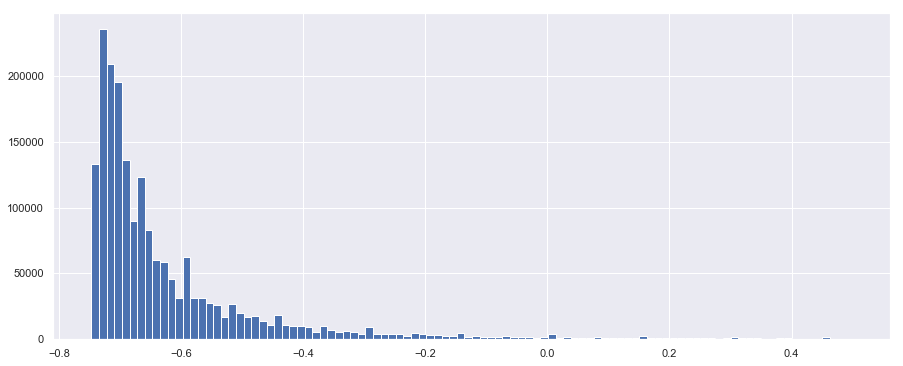

In [14]:
df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'].hist(bins=100)

In [55]:
print('{:.5f}% of the values are less than {} in the new transactions set.'.format(
    len(df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'])/df_new_trans.shape[0],
    threshold
))

0.97744% of the values are less than 0.5 in the new transactions set.


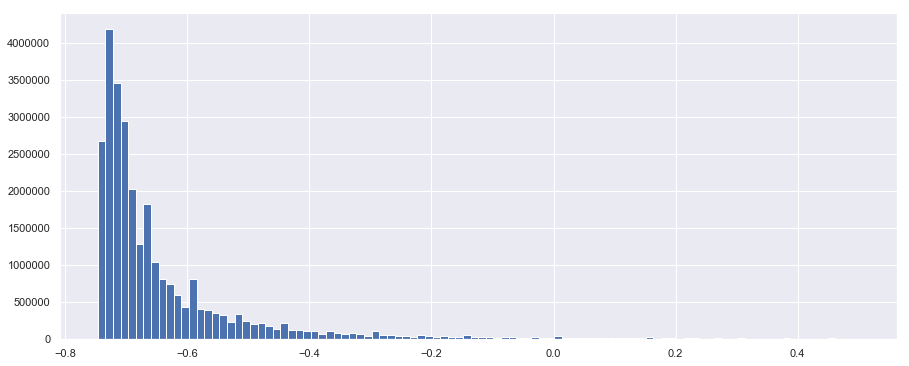

In [56]:
df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'].hist(bins=100)

In [57]:
print('{:.5f}% of the values are less than {} in the historical transactions set.'.format(
    len(df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'])/df_hist_trans.shape[0],
    threshold
))

0.98093% of the values are less than 0.5 in the historical transactions set.


In both sets there are outliers, that need to be filtered out before the training.

### merchant_id, merchant_category_id, subsector_id

In [58]:
df_umn = df_new_trans.groupby("merchant_id").size().reset_index().rename({0:'count'}, axis=1)
df_umh = df_hist_trans.groupby("merchant_id").size().reset_index().rename({0:'count'}, axis=1)

In [59]:
displayDataInHTMLTable(
    ['New', 'Historical'],
    ['Less than 10', 'More than 10'],
    [
        ['{:,}'.format(len(df_umn[df_umn['count'] < 10])), '{:,}'.format(len(df_umh[df_umh['count'] < 10]))],
        ['{:,}'.format(len(df_umn[df_umn['count'] > 10])), '{:,}'.format(len(df_umh[df_umh['count'] > 10]))]
    ]
)

,New,Historical
Less than 10,"188,048","133,773"
More than 10,"34,006","185,304"


In [60]:
len(df_new_trans['merchant_category_id'].unique())

314

In [61]:
print('There are {:,} records with -1 value for the merchant_category_id in the new transaction set and there are {:,} records with -1 value in the historical transaction set.'.format(
    len(df_new_trans[df_new_trans['merchant_category_id'] == -1]['merchant_category_id']),
    len(df_hist_trans[df_hist_trans['merchant_category_id'] == -1]['merchant_category_id'])
))

There are 20 records with -1 value for the merchant_category_id in the new transaction set and there are 2,252 records with -1 value in the historical transaction set.


In [62]:
len(df_new_trans['subsector_id'].unique())

41

In [63]:
df_ussn = df_new_trans.groupby("subsector_id").size().reset_index().rename({0:'count'}, axis=1)
df_ussh = df_hist_trans.groupby("subsector_id").size().reset_index().rename({0:'count'}, axis=1)

In [64]:
df_ussn[:5]

,subsector_id,count
0,-1,20
1,1,66913
2,2,15851
3,3,6237
4,4,4302


In [65]:
df_ussh[:5]

,subsector_id,count
0,-1,2252
1,1,695263
2,2,110596
3,3,87853
4,4,59102


### month_lag

In [66]:
print('Number of unique elements of month lag in the new transactions set {} {} and in the historical transactions set {} {}.'.format(
    len(df_new_trans['month_lag'].unique()),
    list(df_new_trans['month_lag'].unique()),
    len(df_hist_trans['month_lag'].unique()),
    list(df_hist_trans['month_lag'].unique())
))

Number of unique elements of month lag in the new transactions set 2 [1, 2] and in the historical transactions set 14 [-8, -7, -6, -5, -11, 0, -3, -9, -4, -1, -13, -10, -12, -2].


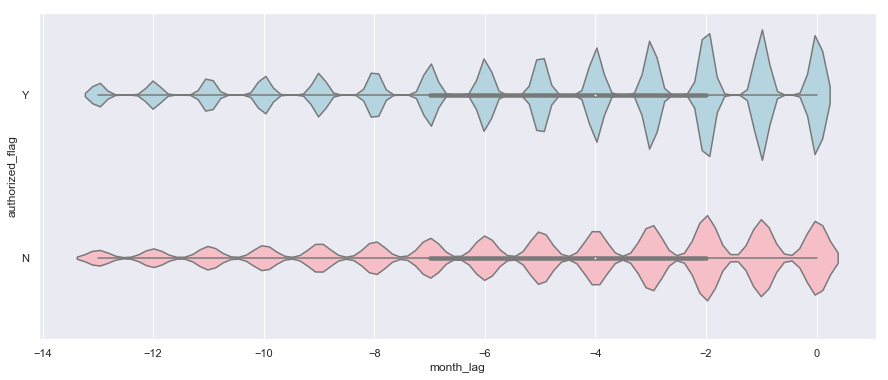

In [67]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.violinplot("month_lag", "authorized_flag", data=df_hist_trans, palette=["lightblue", "lightpink"]);

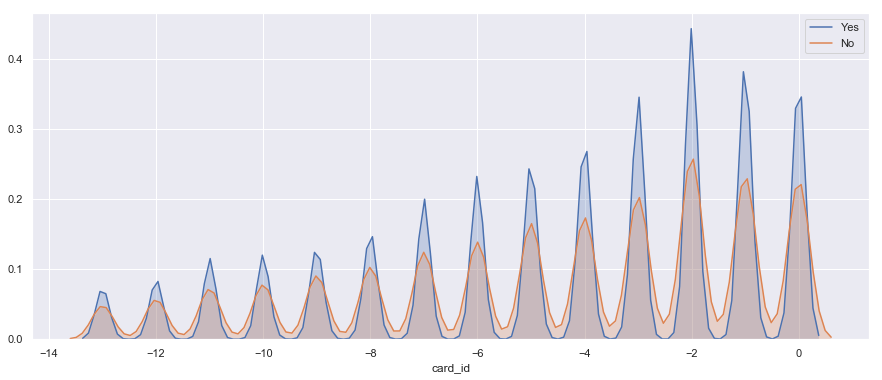

In [68]:
sns.kdeplot(df_hist_trans['month_lag'][df_hist_trans.authorized_flag=='Y'], label='Yes', shade=True)
sns.kdeplot(df_hist_trans['month_lag'][df_hist_trans.authorized_flag=='N'], label='No', shade=True)
plt.xlabel('card_id');

### purchase_date

In [69]:
df_new_trans['purchase_date'].min(), df_new_trans['purchase_date'].max()

('2017-03-01 03:24:51', '2018-04-30 23:59:59')

In [70]:
df_hist_trans['purchase_date'].min(), df_hist_trans['purchase_date'].max()

('2017-01-01 00:00:08', '2018-02-28 23:59:51')

In [19]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [20]:
df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [21]:
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

Text(0,0.5,'Purchase amount')

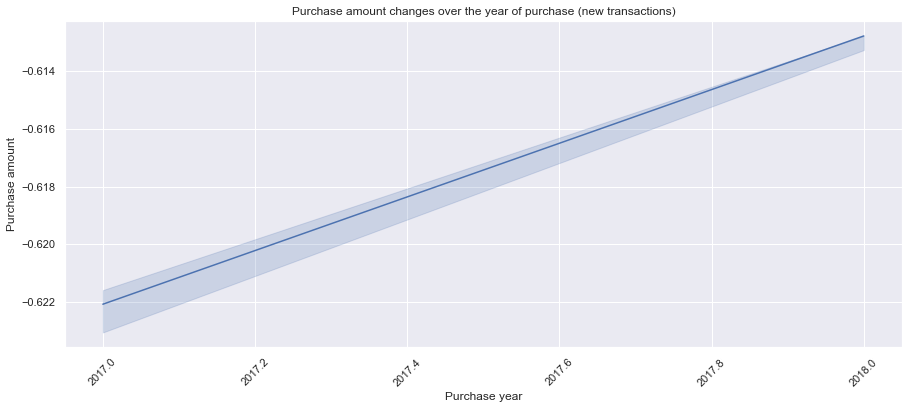

In [74]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_year'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the year of purchase (new transactions)')
ax.set_xlabel('Purchase year')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

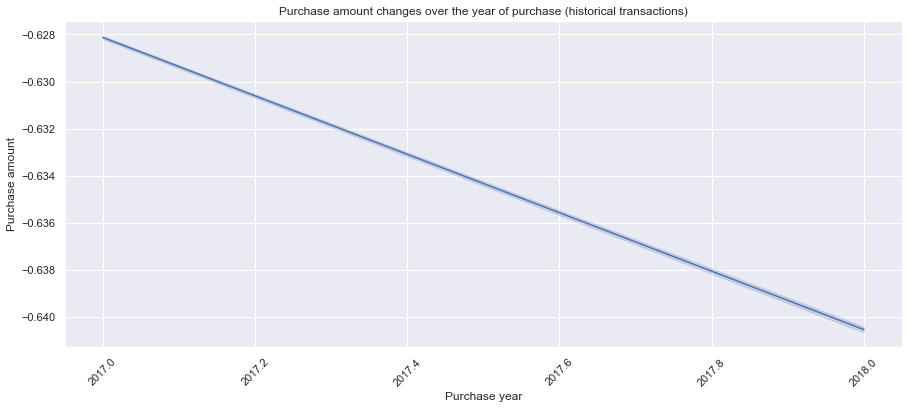

In [75]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_year'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the year of purchase (historical transactions)')
ax.set_xlabel('Purchase year')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

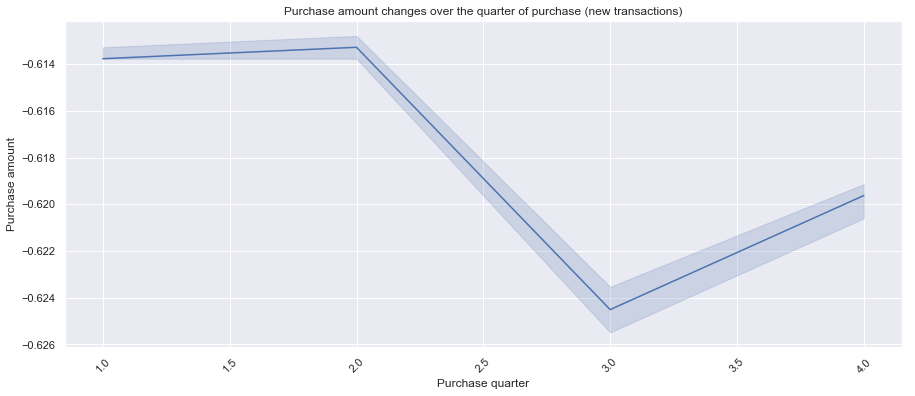

In [ ]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_quarter'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the quarter of purchase (new transactions)')
ax.set_xlabel('Purchase quarter')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

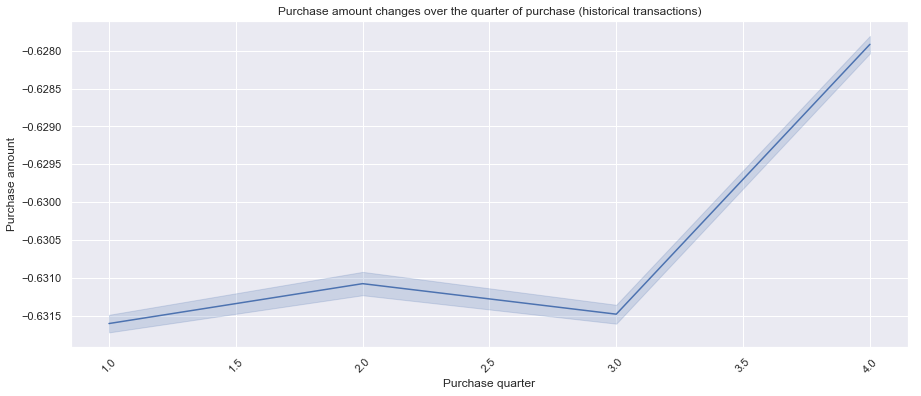

In [19]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_quarter'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the quarter of purchase (historical transactions)')
ax.set_xlabel('Purchase quarter')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

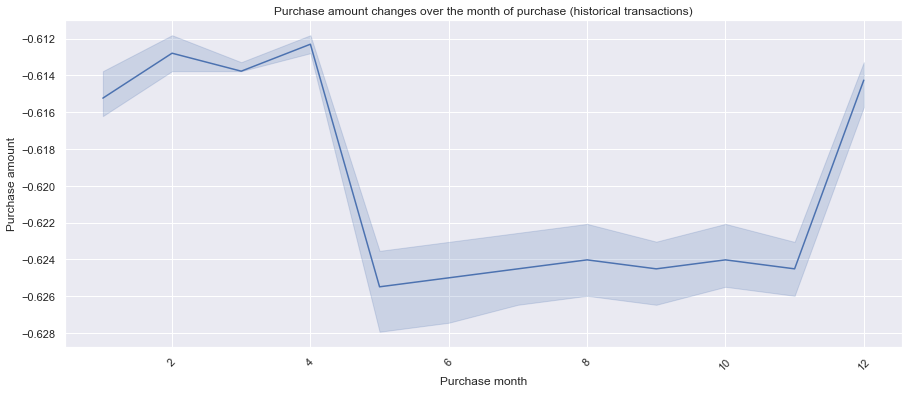

In [20]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_month'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the month of purchase (historical transactions)')
ax.set_xlabel('Purchase month')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

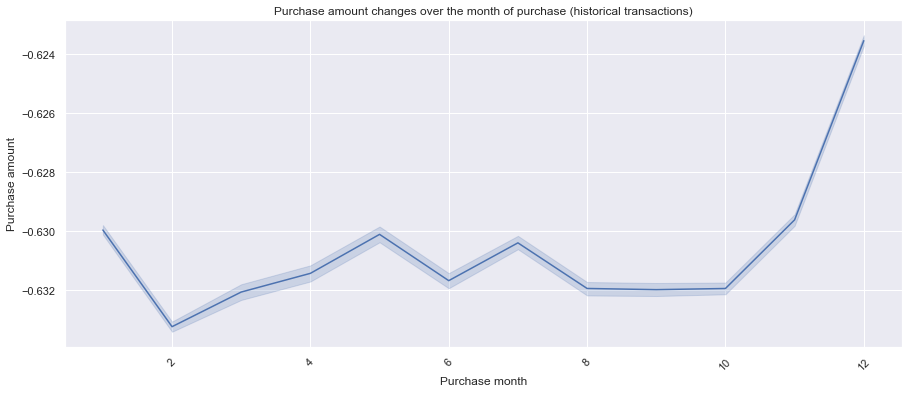

In [22]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_month'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the month of purchase (historical transactions)')
ax.set_xlabel('Purchase month')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

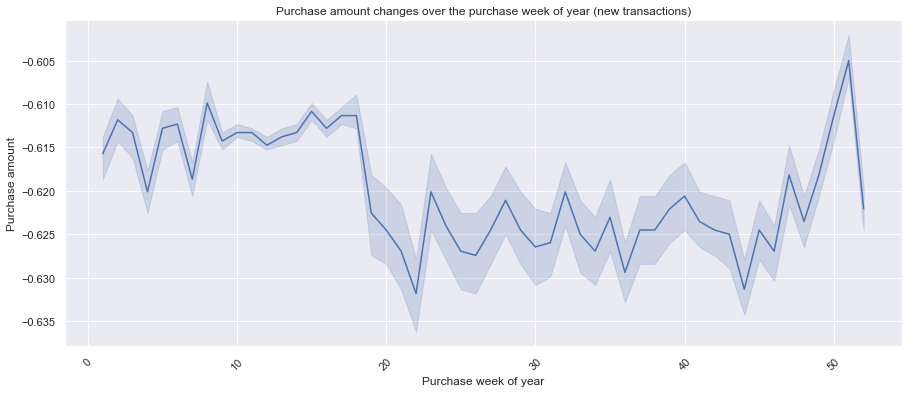

In [21]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_weekofyear'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase week of year (new transactions)')
ax.set_xlabel('Purchase week of year')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

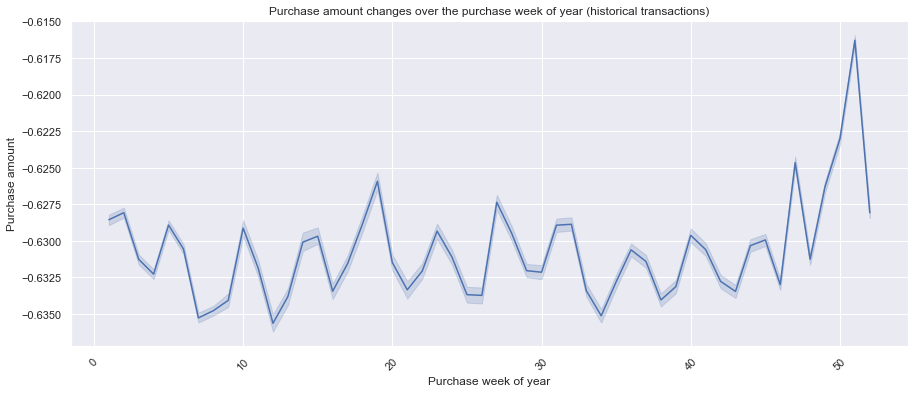

In [23]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_weekofyear'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase week of year (historical transactions)')
ax.set_xlabel('Purchase week of year')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

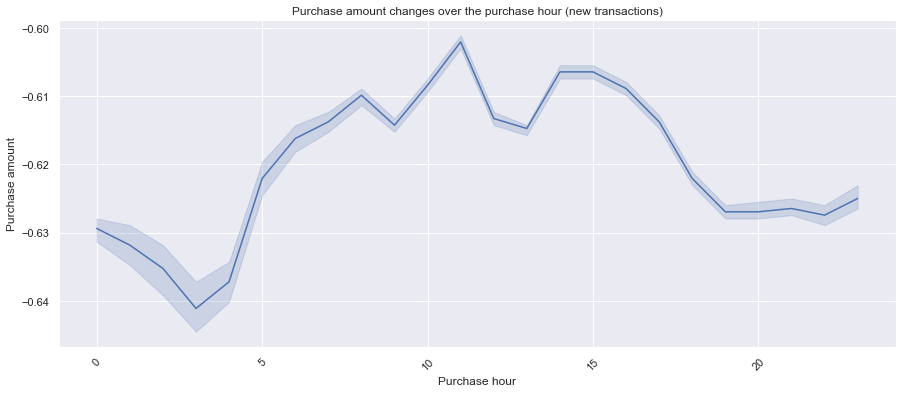

In [22]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_hour'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase hour (new transactions)')
ax.set_xlabel('Purchase hour')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

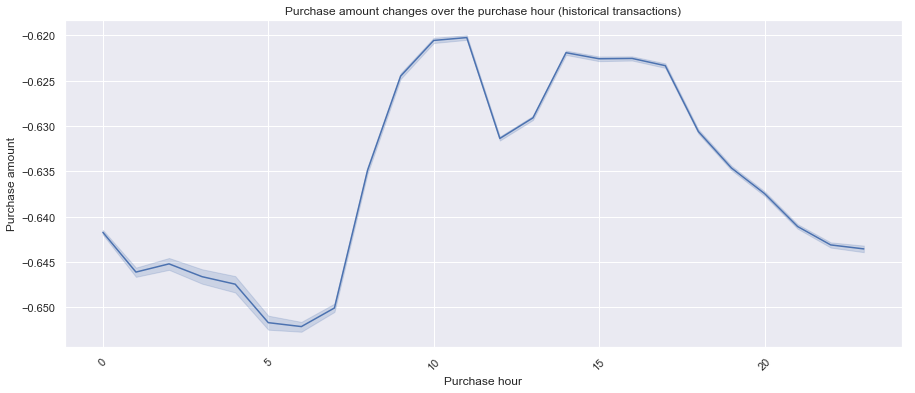

In [24]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_hour'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase hour (historical transactions)')
ax.set_xlabel('Purchase hour')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

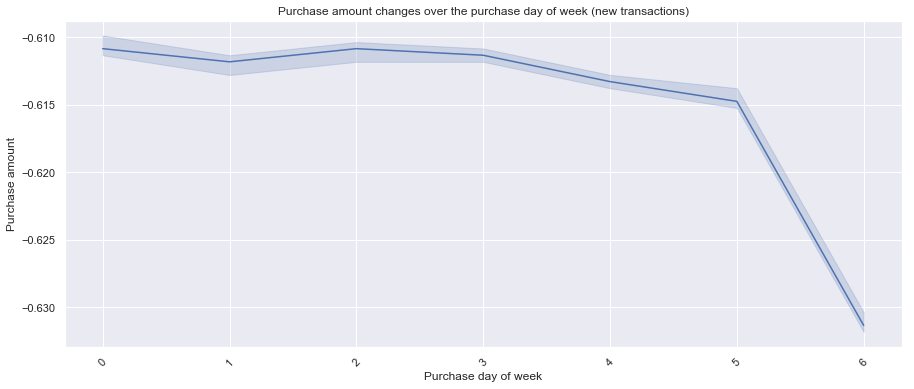

In [23]:
ax = sns.lineplot(x=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_dayofweek'], y=df_new_trans[df_new_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase day of week (new transactions)')
ax.set_xlabel('Purchase day of week')
ax.set_ylabel('Purchase amount')

Text(0,0.5,'Purchase amount')

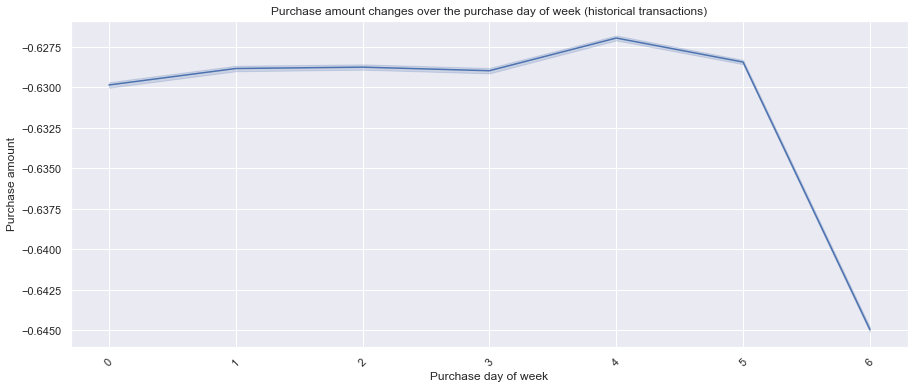

In [25]:
ax = sns.lineplot(x=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_dayofweek'], y=df_hist_trans[df_hist_trans['purchase_amount']<threshold]['purchase_amount'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Purchase amount changes over the purchase day of week (historical transactions)')
ax.set_xlabel('Purchase day of week')
ax.set_ylabel('Purchase amount')

## Merchants

In [26]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

df_merch = reduce_mem_usage(df_merch)

334,696 records and 22 features in merchant set.
Starting memory usage: 56.18 MB
Reduced memory usage: 30.32 MB (46.0% reduction)


In [27]:
df_merch[:3]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0


In [28]:
df_merch.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [29]:
id_array = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'subsector_id', 'state_id', 'city_id', 'merchant_category_id', 'merchant_group_id', 'merchant_id']
for id in id_array:
    print('There are {:,} unique elements in {}.'.format(len(df_merch[id].unique()), id))

There are 2 unique elements in category_1.
There are 5 unique elements in most_recent_sales_range.
There are 5 unique elements in most_recent_purchases_range.
There are 41 unique elements in subsector_id.
There are 25 unique elements in state_id.
There are 271 unique elements in city_id.
There are 324 unique elements in merchant_category_id.
There are 109,391 unique elements in merchant_group_id.
There are 334,633 unique elements in merchant_id.


### numerical_1, numerical_2

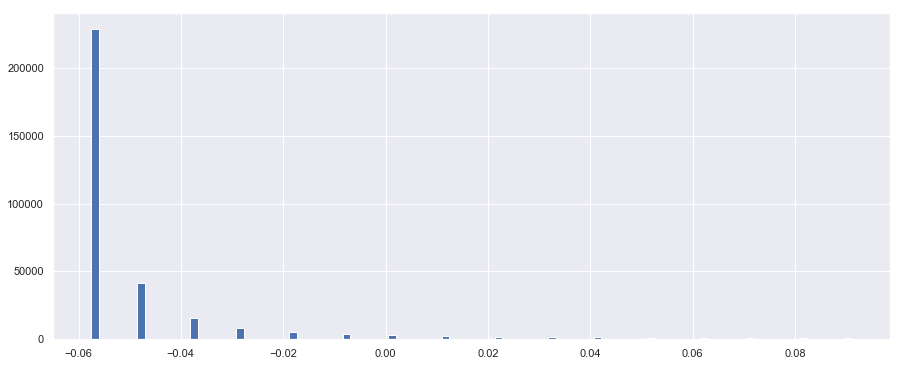

In [30]:
df_merch[df_merch['numerical_1'] < 0.1]['numerical_1'].hist(bins=100)

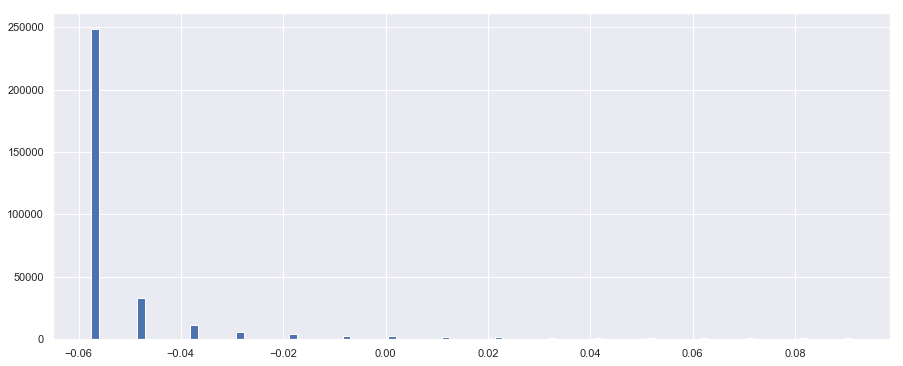

In [31]:
df_merch[df_merch['numerical_2'] < 0.1]['numerical_2'].hist(bins=100)

### category_1, category_2, category_4

In [32]:
df_merch['category_1'].describe()

count     334696
unique         2
top            N
freq      327657
Name: category_1, dtype: object

In [33]:
list(df_merch['category_1'].unique())

['N', 'Y']

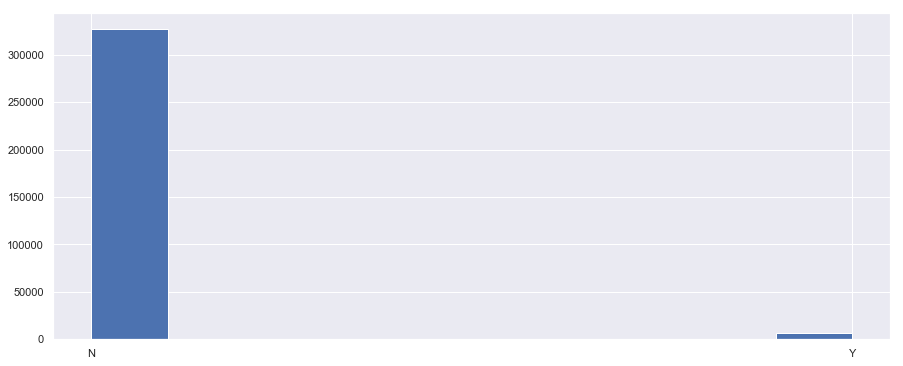

In [34]:
df_merch['category_1'].hist()

In [35]:
df_merch['category_2'].describe()

count    322809.0
mean          NaN
std           0.0
min           1.0
25%           1.0
50%           2.0
75%           4.0
max           5.0
Name: category_2, dtype: float64

In [36]:
list(df_merch['category_2'].unique())

[1.0, 5.0, nan, 2.0, 3.0, 4.0]

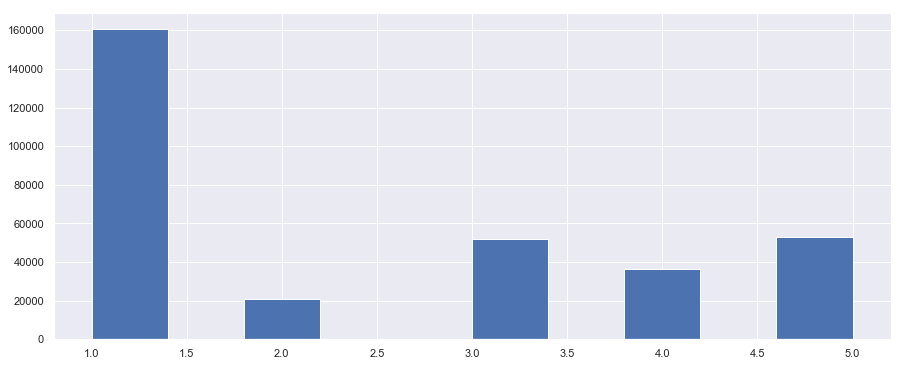

In [37]:
df_merch['category_2'].hist()

In [38]:
df_merch['category_4'].describe()

count     334696
unique         2
top            N
freq      238596
Name: category_4, dtype: object

In [39]:
list(df_merch['category_4'].unique())

['N', 'Y']

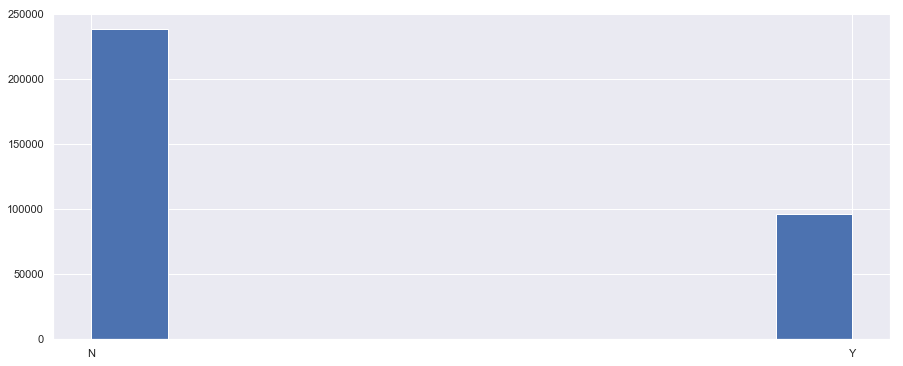

In [40]:
df_merch['category_4'].hist()

### most_recent_sales_range, most_recent_purchases_range

In [41]:
df_merch['most_recent_sales_range'].describe()

count     334696
unique         5
top            E
freq      177104
Name: most_recent_sales_range, dtype: object

In [42]:
list(df_merch['most_recent_sales_range'].unique())

['E', 'C', 'D', 'A', 'B']

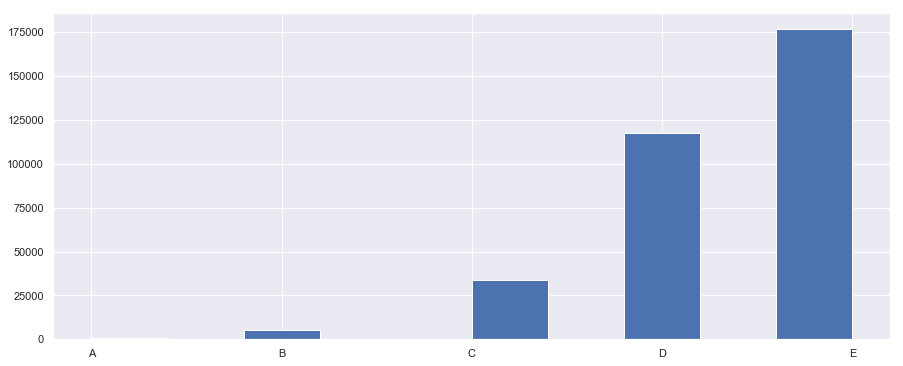

In [43]:
df_merch['most_recent_sales_range'].hist()

In [44]:
df_merch['most_recent_purchases_range'].describe()

count     334696
unique         5
top            E
freq      175309
Name: most_recent_purchases_range, dtype: object

In [45]:
list(df_merch['most_recent_purchases_range'].unique())

['E', 'D', 'C', 'A', 'B']

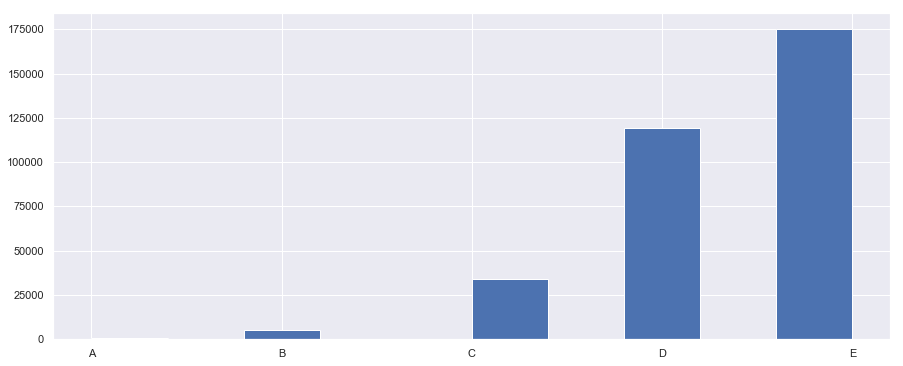

In [46]:
df_merch['most_recent_purchases_range'].hist()

### avg_sales_lag3, avg_sales_lag6, avg_sales_lag12

In [47]:
df_merch['avg_sales_lag3'].describe()

count    334683.000000
mean         13.832988
std        2395.489990
min         -82.129997
25%           0.880000
50%           1.000000
75%           1.160000
max      851844.625000
Name: avg_sales_lag3, dtype: float64

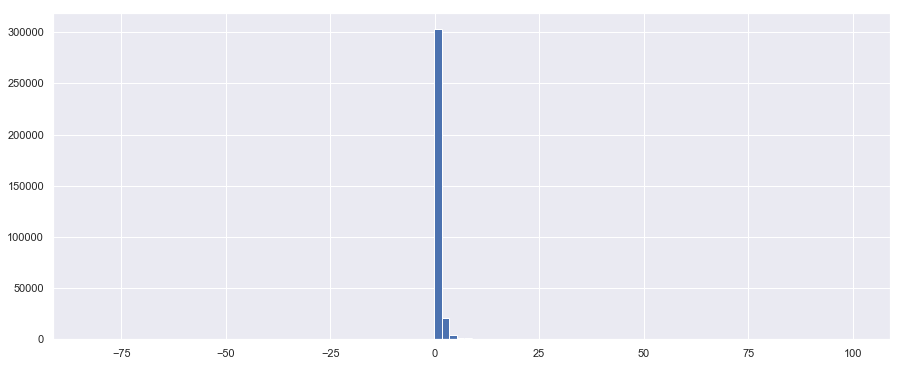

In [48]:
df_merch[df_merch['avg_sales_lag3'] < 100]['avg_sales_lag3'].hist(bins=100)

In [49]:
df_merch['avg_sales_lag6'].describe()

count    3.346830e+05
mean     2.165079e+01
std      3.947108e+03
min     -8.213000e+01
25%      8.500000e-01
50%      1.010000e+00
75%      1.230000e+00
max      1.513959e+06
Name: avg_sales_lag6, dtype: float64

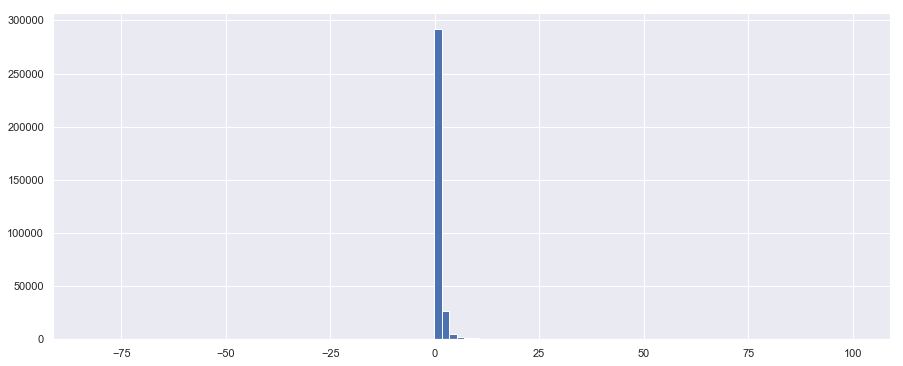

In [50]:
df_merch[df_merch['avg_sales_lag6'] < 100]['avg_sales_lag6'].hist(bins=100)

In [51]:
df_merch['avg_sales_lag12'].describe()

count    3.346830e+05
mean     2.522771e+01
std      5.251842e+03
min     -8.213000e+01
25%      8.500000e-01
50%      1.020000e+00
75%      1.290000e+00
max      2.567408e+06
Name: avg_sales_lag12, dtype: float64

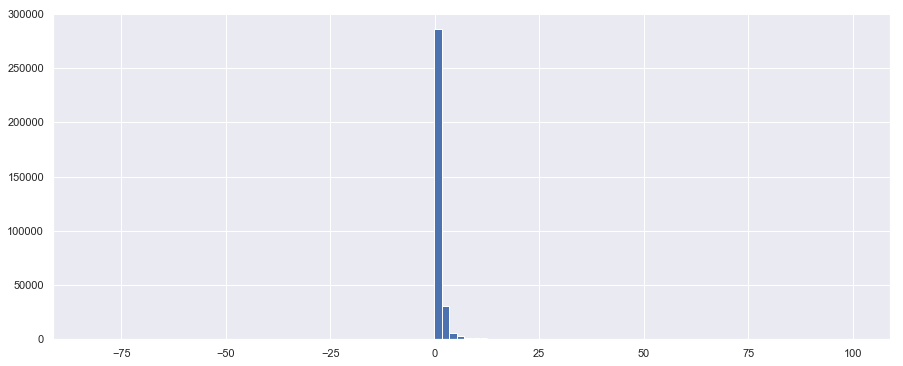

In [52]:
df_merch[df_merch['avg_sales_lag12'] < 100]['avg_sales_lag12'].hist(bins=100)

### avg_purchases_lag6, avg_purchases_lag12

In [53]:
df_merch['avg_purchases_lag6'].describe()

count    3.346960e+05
mean              inf
std               NaN
min      1.670447e-01
25%      9.022475e-01
50%      1.026961e+00
75%      1.215575e+00
max               inf
Name: avg_purchases_lag6, dtype: float64

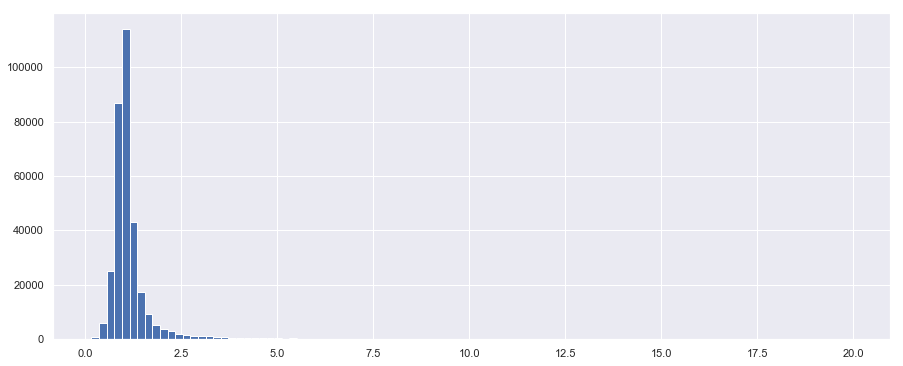

In [54]:
df_merch[df_merch['avg_purchases_lag6'] < 20]['avg_purchases_lag6'].hist(bins=100)

In [55]:
df_merch['avg_purchases_lag12'].describe()

count    3.346960e+05
mean              inf
std               NaN
min      9.832954e-02
25%      8.983333e-01
50%      1.043361e+00
75%      1.266480e+00
max               inf
Name: avg_purchases_lag12, dtype: float64

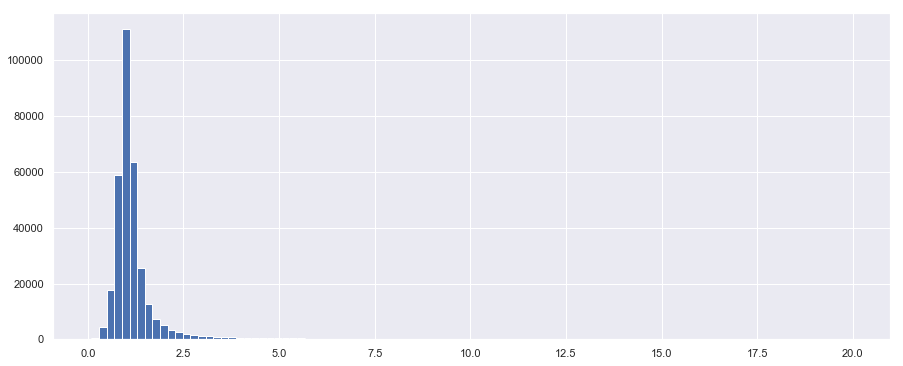

In [56]:
df_merch[df_merch['avg_purchases_lag12'] < 20]['avg_purchases_lag12'].hist(bins=100)

### active_months_lag6, active_months_lag12	

In [57]:
df_merch['active_months_lag6'].describe()

count    334696.000000
mean          5.947397
std           0.394936
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max           6.000000
Name: active_months_lag6, dtype: float64

In [58]:
df_merch['active_months_lag6'].unique()

array([6, 2, 1, 3, 4, 5], dtype=int64)

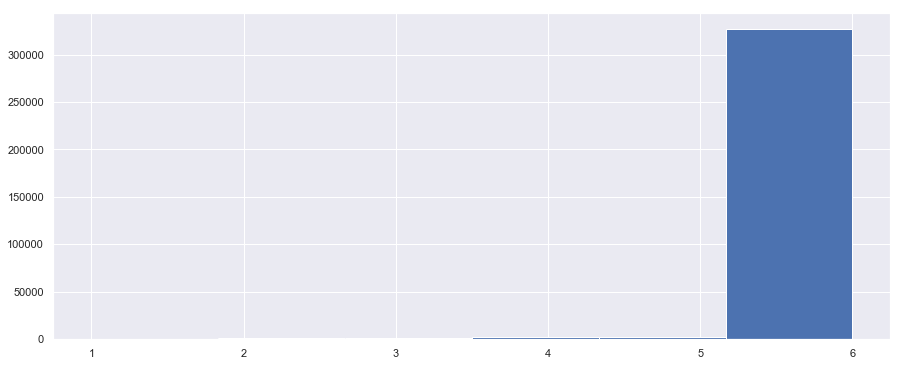

In [59]:
df_merch[df_merch['active_months_lag6'] < 20]['active_months_lag6'].hist(bins=6)

In [60]:
df_merch['active_months_lag12'].describe()

count    334696.000000
mean         11.599335
std           1.520138
min           1.000000
25%          12.000000
50%          12.000000
75%          12.000000
max          12.000000
Name: active_months_lag12, dtype: float64

In [61]:
df_merch['active_months_lag12'].unique()

array([12,  2, 11,  7,  1,  3, 10,  9,  4,  6,  8,  5], dtype=int64)

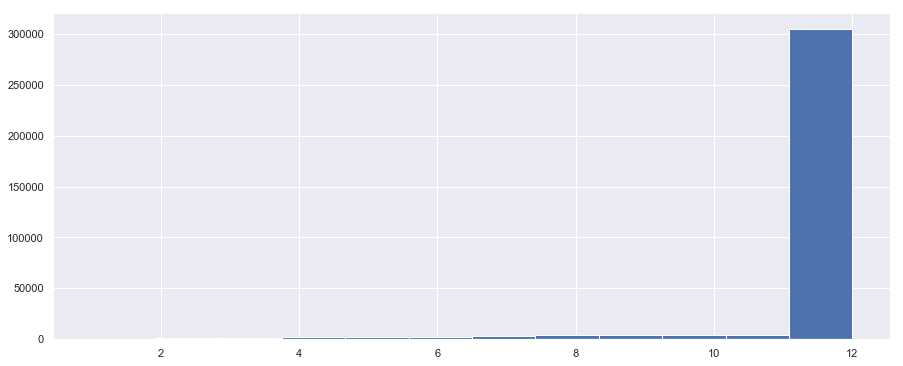

In [62]:
df_merch[df_merch['active_months_lag12'] < 20]['active_months_lag12'].hist(bins=12)